In [20]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.preprocessing import Imputer, LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline

%matplotlib inline
plt.rcParams["figure.figsize"] = (11, 11)

In [2]:
titanic_train = pd.read_csv("../data/train.csv")
titanic_test = pd.read_csv("../data/test.csv")

In [3]:
titanic_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

I'm taking out the names for now

In [14]:
X_train = titanic_train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]
y_train = titanic_train['Survived']

X_test = titanic_test[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare','Embarked']]

In [11]:
# I tried to bin Age but wasn't able to find anything that improved cross-validation

X_train_Age = pd.qcut(X_train.Age, 5)

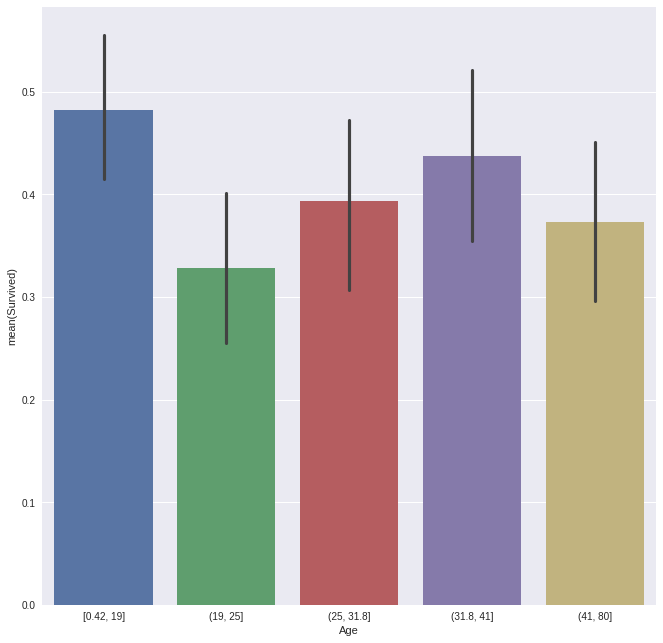

In [12]:
df_train = pd.DataFrame({'Age': X_train_Age,
                         'Survived': y_train})

sns.barplot(x="Age", y="Survived", data=df_train)

In [16]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)
# Need Drop first for to remove multicolinearity

In [18]:
mean_imputer = Imputer(strategy='mean')
X_train = mean_imputer.fit_transform(X_train)
X_test = mean_imputer.transform(X_test)
# Would use MICE, but I'm getting compiler errors

In [ ]:
scaler = 

# Let's get a baseline

In [19]:
ridge = RidgeClassifier()
accuracy_scorer = make_scorer(accuracy_score)
cross_val_score(ridge, X_train_imputed, y_train, scoring=accuracy_scorer, cv = 10).mean()
# This is decent enough baseline

0.79124304846214966